<h1 align=center> RoboAdvisory team task </h1>

<h5 align=right> Автор решения - Колесников Иван </h5>
<h5 align=right> Август, 2022 </h5>

<br>

### Введение

<br>

**Задача**: Предложить оптимальный долгосрочный инвестиционный портфель с горизонтом инвестирования от 5 лет. Реализовать алгоритм NCO из книги Machine Learning for Asset Managers. 

**Исходные данные**: Файл indices.csv содержит данные по дневным ценам индексов. Цены указаны в валюте страны.

**Дополнительные условия**:  В рамках задачи предполагается, что для каждого индекса существует идеальный ETF, который повторяет цену индекса с 100% корреляцией. 

<br>

### Часть 1. Подготовка к анализу

<br>
Загрузка пакетов:

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from arch.covariance.kernel import Bartlett
from statsmodels.stats.moment_helpers import cov2corr
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.optimize import minimize

<br>
Смена директории в случае необходимости:

In [2]:
path = r'C:\Users\Ivan\Desktop\dump\Roboadvisory'
os.chdir(path)

<br>
Загрузка данных и вывод информации о таблице:

In [3]:
df = pd.read_csv('indices.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Columns: 1085 entries, Date to World: World Water TR CW
dtypes: datetime64[ns](1), float64(1084)
memory usage: 20.3 MB


In [4]:
print('Number of NaN:', df.isna().sum().sum())

Number of NaN: 0


<br>
Расчет дневных логарифмических доходностей:

In [5]:
df = df.iloc[:,1:].apply(lambda x: np.diff(np.log(x)))
df.dropna(axis=0, inplace = True)

<br>

### Описание метода

<br>
Описание алгоритма Nested Clustered Optimization (NCO) представлено в разделе 7.6. Данный подход состоит из нескольких шагов:

1. Correlation Clustering - кластеризация активов в группы по корреляции
2. Intra-cluster Weights - выбор весов внутри каждой группы
3. Inter-cluster Weights - выбор весов для каждой из групп

<br>

### Выбранный портфель для оптимизации

<br>

По условиям задачи нам нужно выбрать веса для оптимального долгосрочного инвестиционного портфеля. Ввиду этого, а также для упрощения дальнейших расчетов, оптимальным портфелем для решения данной задачи был выбран Minimum Variance Long Only Portfolio. 

Данный портфель должен хорошо себя показать в качестве "защитной" стратегии, которая будет обезопашена от рыночных колебаний и получит положительную доходность на длинном горизонте. Более того, в частях 7.6.2 и 7.6.3 книги используется такой же портфель.  
Для верной оценки весов будет использован метод расчета очещенной от шума долгосрочной матрицы ковариаций, использующий ядерную оценку плотности Барлетта (Barlett Kernel), также известный как матрица ковариаций Ньюи-Веста (Newey-West). Данный подход позволит нам использовать свойство mean-reversion в волатильностях финансовых рядов, которое заключается в том, что в долгосрочном периоде волатильности всегда возвращаются к их безусловному мат.ожиданию. 

Полученная оценка близка к Shrinkage методам (Oracle Approximating Shrinkage Estimator, Ledoit & Wolf), но содержит более высокие оценки ковариаций. Это объясняется в части 2.5. книги: "Shrinkage accomplishes that without discriminating between noise and signal. As a result, shrinkage can further eliminate an already weak signal." В том числе поэтому предпочтение было отдано оценкам Барлетта.

<br>

### Часть 2. Correlation Clustering

<br>

In [6]:
cov = Bartlett(df).cov # Оценить ковариационную матрицу
corr = cov2corr(cov.long_run) # Перевести в матрицу корреляций

<AxesSubplot:>

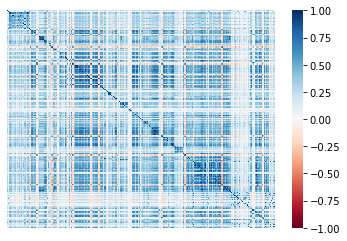

In [7]:
# График неотсортированной матрицы
sns.heatmap(corr, cmap='RdBu', annot=False, xticklabels = False, yticklabels = False, vmin=-1, vmax=1)

<br>
Кластеризация будет производиться с использованием метода hierarchical linkage, который упоминается в книге (раздел 4.3), а также рекомендуется для решения такой задачи на Kaggle / StackOverflow <a href="https://stackoverflow.com/questions/2907919/hierarchical-clustering-on-correlations-in-python-scipy-numpy">[1]</a><a href="https://stats.stackexchange.com/questions/165194/using-correlation-as-distance-metric-for-hierarchical-clustering">[2]</a> и в научных работах (<a href="https://research-api.cbs.dk/ws/portalfiles/portal/62178444/879726_Master_Thesis_Nima_Daniel_15736.pdf">Sjöstrand & Behnejad, 2020</a>). Для определения числа кластеров используется параметр Silhouette Coefficient, оценивающая среднее внутрикластерное и междукластерное расстояние. Его лучшая возможная оценка равна 1, а худшая -1. Данный метод был рекомендован в <a href="https://www.youtube.com/watch?v=pH4wctij1Hk&ab_channel=Hudson%26Thames">блоге </a> инвестиционной компании Hudson & Thames. Можно также строить дендрограммму, но для большого количества активов это не является оптимальным решением.
<br>

In [8]:
# Оценим попарные дистанции и инициализируем алгоритм. Метрика Squared Euqlidean рекомендуется в одной из ссылок выше.
dist  = pdist(corr, 'sqeuclidean')
hierarchy = linkage(dist, method='ward')

In [9]:
# Оценим Silhouette Coefficient для разного числа кластеров и построим график оценочного процесса
max_amount = 10
max_score = -10*10
count = 0
i = 20
score_arr = []
i_arr = []

while count < 10:
    
    labels = fcluster(hierarchy, i, criterion='maxclust')
    score = silhouette_score(corr, labels, metric="sqeuclidean")
    i += 20
    
    # Данные для графика
    score_arr.append(score)
    i_arr.append(i)
    
    if score > max_score:
        max_score = score
        max_amount = i
        count = 0
    else:
        count += 1

Optimal number of clusters is 500. Corresponding Silhouette coef is 0.576


Text(0.5, 1.0, 'Tuning process')

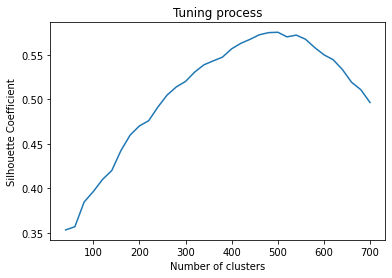

In [10]:
print(f'Optimal number of clusters is {max_amount}. Corresponding Silhouette coef is {round(max_score,3)}')

plt.plot(i_arr, score_arr)
plt.ylabel('Silhouette Coefficient')
plt.xlabel('Number of clusters')
plt.title('Tuning process')

In [11]:
# Итоговая классификация
labels = fcluster(hierarchy, max_amount, criterion='maxclust')

<AxesSubplot:>

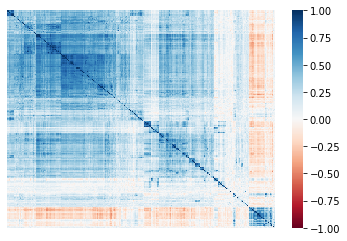

In [12]:
# Отсортированная матрица корреляций
order = np.argsort(labels) 
corr_sorted = np.array(corr)[order, :][:, order]
sns.heatmap(corr_sorted, cmap='RdBu', annot=False, xticklabels = False, yticklabels = False, vmin=-1, vmax=1)

Text(0.5, 0, 'Category')

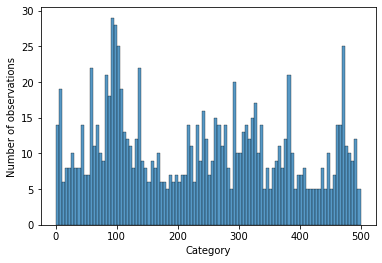

In [13]:
# График числа переменных в группе
sns.histplot(x = labels, bins=100)
plt.ylabel('Number of observations')
plt.xlabel('Category')

<br>

### Часть 3. Intra-cluster (Within) Weights

<br>

Напомню, что используется Minimum Variance Optimization с Long Only constaints.

In [14]:
# Dict для сохранения результатов
within_weights = {}

# Расчет ведется для каждого лейбла по отдельности
for i in np.unique(labels):
    
    # Определить позицию активов в изначальной таблице. Создать сабсет.
    idx = np.where(labels == i)[0]
    temp = df.iloc[:, idx]
    n = temp.shape[1]
    
    # Сохранить названия активов и индексы
    within_weights[str(i)] = {}
    within_weights[str(i)]['Names'] = temp.columns
    within_weights[str(i)]['idx'] = idx
    
    # Если 1 элемент в кластере, то расчет не производится. Вес равен 1. Также сохраняется вариация портфеля группы.
    if n == 1:
        within_weights[str(i)]['Weights'] = np.array([1])
        within_weights[str(i)]['Var'] = float( np.array(cov.long_run)[idx, idx] )
        
    # Если больше 1 актива - оптимизируем
    else:
        # Ковариационная матрица
        var = np.array(cov.long_run)[idx, :][:, idx]
        # Функция для оптимизации
        portf_var = lambda w: np.linalg.multi_dot([np.transpose(w), var, w]) * 0.5
        # Mинимизация
        res = minimize(portf_var, x0 = np.ones(n) / n, bounds = [(0,1)] * n )
        # Сохранение результата
        within_weights[str(i)]['Weights'] = res['x']
        within_weights[str(i)]['Var'] = res['fun']

In [15]:
# Пример записи для кластера
within_weights['1']

{'Names': Index(['Australia: S&P/ASX 200 Banks', 'Australia: S&P/ASX 200 Financials',
        'Australia: S&P/ASX 300 Banks', 'Australia: S&P/ASX 300 Financials',
        'Australia: S&P/ASX 300 Financials ex Property Trusts',
        'Australia: S&P/ASX Financials ex REIT'],
       dtype='object'),
 'idx': array([16, 24, 48, 57, 58, 86], dtype=int64),
 'Weights': array([0.        , 0.00862359, 0.        , 0.00935877, 0.0022181 ,
        0.001678  ]),
 'Var': 1.8490585084815305e-08}

<br>

### Часть 4. Inner-cluster (Between) Weights

<br>

В части 7.5. книги написано, что матрица ковариаций групп (при верной кластеризации) будет близка к диагональной и "the optimization problem is close to the ideal Markowitz case". Таким образом, нам не нужно учитывать ковариации для выбора весов и можно упростить функцию для оптимизацию.

In [16]:
# Извлекаем вариацию портфелей из Dict 
cov2 = [within_weights[x]['Var'] for x in within_weights.keys()]
# Количество групп
n = len(cov2)
# Функция для оптимизации
portf_var = lambda w: np.dot(cov2, w)
# Минимизация (те же условия)
res = minimize(portf_var, x0 = np.ones(n) / n, bounds = [(0,1)] * n )['x']

<br>

### Часть 5. Веса индивидуальных активов 
<br>

Расчитаем веса индивидуальных активов путем умножения весов групп на внутригрупповые веса

In [17]:
Weights = []
Assets = []

for i, j in enumerate(res):
   Weights += list(within_weights[str(i+1)]['Weights'] * j)
   Assets += within_weights[str(i+1)]['Names'].tolist()

# Cтандартизация весов
Weights = np.array(Weights) / np.sum(Weights)
    
# Выведем активы с ненулевыми весами
Final_portf = [ (x,y) for x,y in zip(Weights, Assets) if x > 0]
Final_portf

[(0.07736334203542362, 'Australia: S&P/ASX 200 Diversified Financials'),
 (0.058780627616707236, 'Australia: S&P/ASX 100 Industrials'),
 (0.040575873919255025, 'Germany: Retail Price'),
 (0.06507778773814153, 'Denmark: OMX Copenhagen Small Cap GI'),
 (0.02541152827381641, 'World: World Water CW'),
 (0.047850582990614406, 'United states: NQ Dividend Achievers'),
 (0.06626218091256529, 'Germany: Chemicals'),
 (0.01575100280239133, 'Denmark: Copenhagen Ex OMXC20 GI'),
 (0.0553746609461167, 'Germany: Technology Price'),
 (0.03659358024353968, 'United states: ARCA Japan'),
 (0.0010622617015816614, 'Denmark: Copenhagen General Retailers'),
 (0.0015063483860603866, 'Denmark: Copenhagen Retail'),
 (0.0920227625290653, 'Germany: Pharma & Healthcare'),
 (0.01350390698189403, 'World: Bloomberg Unleaded Gasoline TR'),
 (0.004480608289252721, 'World: Bloomberg Silver TR'),
 (0.03789213172031862, 'World: Bloomberg Cotton TR'),
 (0.03682336643924331, 'World: Bloomberg Zinc TR'),
 (0.08922052813737376

Состав портфеля включает в себя диверсифицированные индексы развитых регионов, стран и индустрий. Он выглядит как достойный кандидат для долгосрочного инвестирования.

<br>

### Часть 6. Анализ исторического поведения портфеля

<br>

NCO Sharpe ratio is 0.0571
Equal-weighted Sharpe ratio is 0.0548


Text(0.5, 1.0, 'Return of the NCO portfolio')

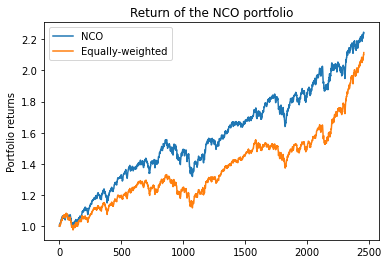

In [18]:
# Расчитаем доходности для NCO портфеля и переведем их в арифметические
port_returns = df.dot(Weights)
port_returns = np.exp(port_returns) - 1

# Безрисковый актив  - United states: TR US 5 Years Government Benchmark, как альтернатива для долгосрочных инвеcтиций
rf = df['United states: TR US 5 Years Government Benchmark']
rf = np.exp(rf) - 1

# Пренебрегаем безрисковой доходностью для упрощения расчета
print(f'NCO Sharpe ratio is {round( np.mean(port_returns - rf) / np.std(port_returns), 4)}')

# Расчитаем доходности для равновзвешенного портфеля и переведем их в арифметические
eq_returns = np.mean(df, axis = 1)
eq_returns = np.exp(eq_returns) - 1

print(f'Equal-weighted Sharpe ratio is {round( np.mean(eq_returns - rf) / np.std(eq_returns), 4)}')

# Построим график кумулятивной доходности для портфелей
port_returns = np.cumprod(1+port_returns)
port_returns = np.insert( np.array(port_returns), 0, 1)

eq_returns = np.cumprod(1+eq_returns)
eq_returns = np.insert( np.array(eq_returns), 0, 1)

plt.plot(port_returns, label = 'NCO')
plt.plot(eq_returns, label = 'Equally-weighted')
plt.legend()
plt.ylabel('Portfolio returns')
plt.title('Return of the NCO portfolio')

Как мы можем заменить, Sharpe ratio и кумулятивная доходность NCO портфеля выше. Таким образом, он может использоваться как отдельная низкоризковая долгосрочная стратегия или для диверсификации общего портфеля.

Стоит отметить, что для полноценного анализа нужно учитывать ребалансировку, которая будет выше у Equally-Weighted.